# Overfitting and regularization (with ``gluon``)

Now that we've built a [regularized logistic regression model from scratch](regularization-scratch.html), let's make this more efficient with ``gluon``. We recommend that you read the latter for a description as to why regularization is a good idea. As always, we begin by loading libraries and some data.

[**REFINED DRAFT - RELEASE STAGE: CATFOOD**]

In [1]:
from __future__ import print_function
import mxnet as mx
from mxnet import autograd
from mxnet import gluon
import mxnet.ndarray as nd
import numpy as np
ctx = mx.cpu()

# for plotting purposes
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## The MNIST Dataset

In [2]:
mnist = mx.test_utils.get_mnist()
num_examples = 1000
batch_size = 64
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["train_data"][:num_examples],
                               mnist["train_label"][:num_examples].astype(np.float32)), 
                               batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["test_data"][:num_examples],
                               mnist["test_label"][:num_examples].astype(np.float32)), 
                               batch_size, shuffle=False)

## Multiclass Logistic Regression

In [3]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(10))

## Parameter initialization


In [4]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

## Softmax Cross Entropy Loss

In [5]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

## Optimizer

By default ``gluon`` tries to keep the coefficients from diverging by using a *weight decay* penalty. So, to get the real overfitting experience we need to switch it off. We do this by passing `'wd': 0.0'` when we instantiate the trainer. 

In [6]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'wd': 0.0})

## Evaluation Metric

In [7]:
def evaluate_accuracy(data_iterator, net, loss_fun):
    acc = mx.metric.Accuracy()
    loss_avg = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        output = net(data)
        loss = loss_fun(output, label) 
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return acc.get()[1], loss_avg

def plot_learningcurves(loss_tr,loss_ts, acc_tr,acc_ts):
    xs = list(range(len(loss_tr)))
    
    f = plt.figure(figsize=(12,6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)
    
    fg1.set_xlabel('epoch',fontsize=14)
    fg1.set_title('Comparing loss functions')
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True,which="both")

    fg1.legend(['training loss', 'testing loss'],fontsize=14)
    
    fg2.set_title('Comparing accuracy')
    fg1.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, acc_tr)
    fg2.plot(xs, acc_ts)
    fg2.grid(True,which="both")
    fg2.legend(['training accuracy', 'testing accuracy'],fontsize=14)

## Execute training loop

Completed epoch 1. Train Loss: 2.2037088275, Test Loss 2.2286785692, Train_acc 0.188, Test_acc 0.163
Completed epoch 21. Train Loss: 0.893416512758, Test Loss 1.1039121747, Train_acc 0.822, Test_acc 0.735
Completed epoch 41. Train Loss: 0.652327498421, Test Loss 0.873137623072, Train_acc 0.866, Test_acc 0.765
Completed epoch 61. Train Loss: 0.546028014272, Test Loss 0.768615357578, Train_acc 0.879, Test_acc 0.774
Completed epoch 81. Train Loss: 0.484074600041, Test Loss 0.706401664764, Train_acc 0.894, Test_acc 0.799
Completed epoch 101. Train Loss: 0.444923525676, Test Loss 0.664441943169, Train_acc 0.902, Test_acc 0.813
Completed epoch 121. Train Loss: 0.407917639241, Test Loss 0.63365178369, Train_acc 0.908, Test_acc 0.816
Completed epoch 141. Train Loss: 0.380045365542, Test Loss 0.610164759681, Train_acc 0.915, Test_acc 0.82
Completed epoch 161. Train Loss: 0.359072620049, Test Loss 0.592256868258, Train_acc 0.919, Test_acc 0.824
Completed epoch 181. Train Loss: 0.342955171131, Te

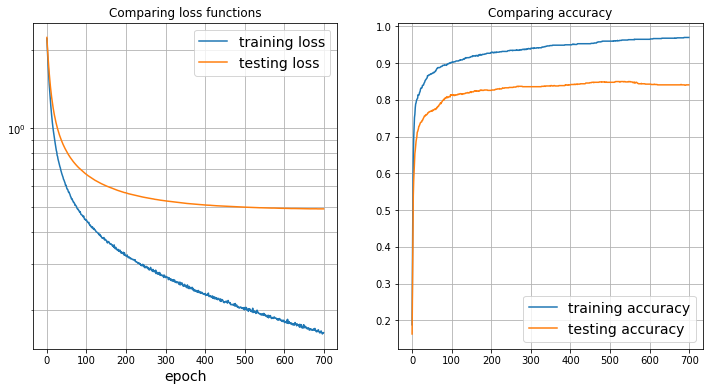

In [8]:
epochs = 700
moving_loss = 0.
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
        cross_entropy.backward()
        trainer.step(data.shape[0])
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(cross_entropy).asscalar()
        est_loss = moving_loss/(1-0.99**niter)
            
    test_accuracy, test_loss = evaluate_accuracy(test_data, net, loss)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net, loss)
    
    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)
    
        
    if e % 20 == 0:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" % 
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))     

## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)

## Regularization

Now let's see what this mysterious *weight decay* is all about. We begin with a bit of math. When we add an L2 penalty to the weights we are effectively adding $\frac{\lambda}{2} \|w\|^2$ to the loss. Hence, every time we compute the gradient it gets an additional $\lambda w$ term that is added to $g_t$, since this is the very derivative of the L2 penalty. As a result we end up taking a descent step not in the direction $-\eta g_t$ but rather in the direction $-\eta (g_t + \lambda w)$. This effectively shrinks $w$ at each step by $\eta \lambda w$, thus the name weight decay. To make this work in practice we just need to set the weight decay to something nonzero.

Completed epoch 1. Train Loss: 2.14699037373, Test Loss 2.2012976557, Train_acc 0.258, Test_acc 0.21
Completed epoch 21. Train Loss: 0.897427085787, Test Loss 1.10325625166, Train_acc 0.829, Test_acc 0.731
Completed epoch 41. Train Loss: 0.65643049404, Test Loss 0.870614867657, Train_acc 0.863, Test_acc 0.764
Completed epoch 61. Train Loss: 0.55040868558, Test Loss 0.766712084413, Train_acc 0.883, Test_acc 0.783
Completed epoch 81. Train Loss: 0.494966622442, Test Loss 0.705847013742, Train_acc 0.89, Test_acc 0.794
Completed epoch 101. Train Loss: 0.448520205915, Test Loss 0.66454987973, Train_acc 0.9, Test_acc 0.805
Completed epoch 121. Train Loss: 0.414661627263, Test Loss 0.635127693415, Train_acc 0.909, Test_acc 0.813
Completed epoch 141. Train Loss: 0.388363324106, Test Loss 0.612139802426, Train_acc 0.916, Test_acc 0.82
Completed epoch 161. Train Loss: 0.367833500728, Test Loss 0.595174005255, Train_acc 0.918, Test_acc 0.827
Completed epoch 181. Train Loss: 0.353276398964, Test L

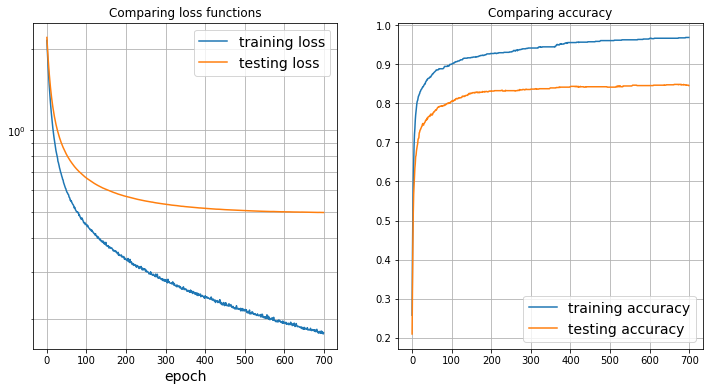

In [9]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx, force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'wd': 0.001})

moving_loss = 0.
niter=0
loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
        cross_entropy.backward()
        trainer.step(data.shape[0])
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(cross_entropy).asscalar()
        est_loss = moving_loss/(1-0.99**niter)
            
    test_accuracy, test_loss = evaluate_accuracy(test_data, net,loss)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net, loss)
    
    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)
    
    if e % 20 == 0:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" % 
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))  
        
## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)

As we can see, the test accuracy improves a bit. Note that the amount by which it improves actually depends on the amount of weight decay. We recommend that you try and experiment with different extents of weight decay. For instance, a larger weight decay (e.g. $0.01$) will lead to inferior performance, one that's larger still ($0.1$) will lead to terrible results. This is one of the reasons why tuning parameters is quite so important in getting good experimental results in practice.

## Next
[Loss functions](../chapter02_supervised-learning/loss.ipynb)

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)